## Import libraries

In [1]:
# import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import mean, col, count, min, max, avg, sum, hour, date_format, year, month
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType, DoubleType, StringType, LongType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window

%matplotlib inline

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("Individual").getOrCreate()

# Load the dataset into a DataFrame
fraudTrain = spark.read.csv('file:///home/cloudera/Downloads/train.csv', header=True, inferSchema=True)
fraudTest = spark.read.csv('file:///home/cloudera/Downloads/test.csv', header=True, inferSchema=True)
fraudTrain.show(3)

+----------+---------------------+----------------+--------------------+-----------+------+---------+--------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+-------------------+--------------------+----------+---------+-----------+--------+
|Unnamed: 0|trans_date_trans_time|          cc_num|            merchant|   category|   amt|    first|    last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|                dob|           trans_num| unix_time|merch_lat| merch_long|is_fraud|
+----------+---------------------+----------------+--------------------+-----------+------+---------+--------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+-------------------+--------------------+----------+---------+-----------+--------+
|         0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|   misc_net|  4.97| Jennifer|   Banks

## Show basic information about dataset

In [3]:
# show the columns of the dataset
fraudTrain.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: timestamp (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [4]:
# show the total number of the dataset
print('there are totally {} rows in train dataset'.format(fraudTrain.count()))
print('there are totally {} rows in test dataset'.format(fraudTest.count()))

there are totally 500000 rows in train dataset
there are totally 100000 rows in test dataset


In [5]:
# show the feature number of the dataset
print('there are totally {} features in dataset'.format(len(fraudTrain.columns)))

there are totally 23 features in dataset


In [6]:
# Function to detect and replace "NA" values in the dataset
def detect_na(data):
    data_nadrop = fraudTrain.na.drop()
    if data_nadrop.count() == data.count():
        print('No missing values or null values')
    else:
        print('Existing missing values, need further deletion')

detect_na(fraudTrain)

No missing values or null values


In [7]:
# function to check if duplicate exists in data
# Function to check and remove duplicate rows from the dataset
def check_duplicates(data):
    initial_row_count = data.count()
    data = data.dropDuplicates()
    final_row_count = data.count()
    
    if initial_row_count != final_row_count:
        print("Removed {} duplicate rows.".format(initial_row_count - final_row_count))
    else:
        print("No duplicate rows found.")
        
    return data

fraudTrain = check_duplicates(fraudTrain)

No duplicate rows found.


## Classify the numeric and categorial data

In [8]:
# Function to divide features into numeric and categorical types
def feature_division(data, features):
    
    # gain features of the dataset
    input_features =  [i for i in features]

    # gain number features 
    num_features = [i for i in input_features 
         if isinstance(data.schema[i].dataType, IntegerType) or 
         isinstance(data.schema[i].dataType, DoubleType) or 
         isinstance(data.schema[i].dataType, LongType)]

    ## gain categorial features 
    cat_features = [i for i in input_features if isinstance(data.schema[i].dataType, StringType)]
    
    return num_features, cat_features

# devide features with data
numeric_columns, categorical_columns = feature_division(fraudTrain, fraudTrain.columns)
print('Numeric columns are: ', numeric_columns)
print('\nCategorical columns are: ', categorical_columns) 

Numeric columns are:  ['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

Categorical columns are:  ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'trans_num']


In [9]:
# show basic statistic data for numeric data
fraudTrain_numeric = fraudTrain.select([column for column in fraudTrain.columns if column in numeric_columns])
for column in fraudTrain_numeric.columns:
    fraudTrain_numeric.describe(column).show()

+-------+------------------+
|summary|        Unnamed: 0|
+-------+------------------+
|  count|            500000|
|   mean|     647609.662982|
| stddev|374628.38856818655|
|    min|                 0|
|    max|           1296673|
+-------+------------------+

+-------+--------------------+
|summary|              cc_num|
+-------+--------------------+
|  count|              500000|
|   mean|4.191975062438592E17|
| stddev|1.311774813995875...|
|    min|         60416207185|
|    max| 4992346398065154184|
+-------+--------------------+

+-------+------------------+
|summary|               amt|
+-------+------------------+
|  count|            500000|
|   mean| 74.67955701999999|
| stddev|172.76117650141714|
|    min|               1.0|
|    max|           28948.9|
+-------+------------------+

+-------+------------------+
|summary|               zip|
+-------+------------------+
|  count|            500000|
|   mean|      48794.940558|
| stddev|26894.850181848295|
|    min|             

## Feature engineering

In [10]:
# Deal with some varibales and gain some new features
fraudTrain = fraudTrain.withColumn('Hour', hour('trans_date_trans_time'))
fraudTrain = fraudTrain.withColumn('Month', month('trans_date_trans_time'))
fraudTrain = fraudTrain.withColumn('week_day', date_format('trans_date_trans_time', 'u'))
fraudTrain = fraudTrain.withColumn('age', year('trans_date_trans_time')-year('dob'))

# Divide the is_fraud to 1 and 0
fraudTrain_0 = fraudTrain.filter(fraudTrain.is_fraud == 0)
fraudTrain_1 = fraudTrain.filter(fraudTrain.is_fraud == 1)

print('The length of data not being fraud: ', fraudTrain_0.count())
print('The length of data being fraud: ', fraudTrain_1.count())

The length of data not being fraud:  492494
The length of data being fraud:  7506


In [11]:
# Same feature engineering methods in test dataset
fraudTest = fraudTest.withColumn('Hour', hour('trans_date_trans_time'))
fraudTest = fraudTest.withColumn('Month', month('trans_date_trans_time'))
fraudTest = fraudTest.withColumn('week_day', date_format('trans_date_trans_time', 'u'))
fraudTest = fraudTest.withColumn('age', year('trans_date_trans_time')-year('dob'))

## EDA of the dataset

+--------+------+------------------+
|is_fraud| count|        Percentage|
+--------+------+------------------+
|       1|  7506|1.5011999999999999|
|       0|492494|           98.4988|
+--------+------+------------------+



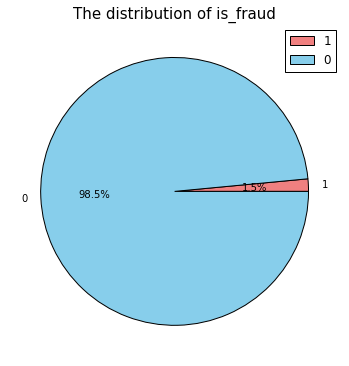

In [12]:
# calculate the distribution of people of fraud and not fraud - predictive variable
distribution = fraudTrain.groupBy('is_fraud').count().withColumn("Percentage", (col("count") / fraudTrain.count()) * 100)
distribution.show()

categories = distribution.select('is_fraud').rdd.flatMap(lambda x: x).collect()
counts = distribution.select("count").rdd.flatMap(lambda x: x).collect()

# plt the pie chart of fruad distribution
colors = ['lightcoral', 'skyblue']
plt.figure(figsize = (6,6))
plt.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=0)
plt.legend(categories, loc='best')
plt.title('The distribution of is_fraud', fontsize=15)
plt.show()

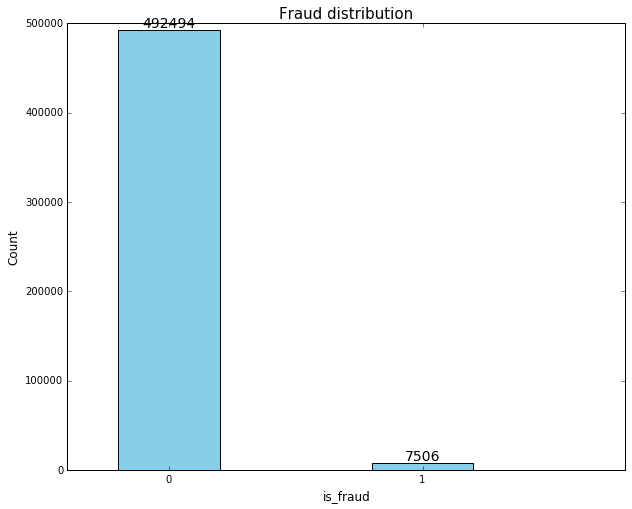

In [13]:
# plt the bar char and show specific number of each categorial
fraud_count = fraudTrain.groupBy('is_fraud').count().collect()
fraud_label = [row['is_fraud'] for row in fraud_count]
counts_0 = [row['count'] for row in fraud_count]

width=0.4
cat_indices = list(range(len(fraud_label)))
plt.figure(figsize = (10,8))

bars = plt.bar(fraud_label, counts_0, color='skyblue',width=width,label='class 0')
x_position_for_labels = [bar.get_x() + bar.get_width()/2 for bar in bars]

for bar, value in zip(bars, counts_0): 
    plt.text(bar.get_x() + bar.get_width() / 2, value, "{}".format(value), ha="center", va="bottom", fontsize=14)

plt.xticks(x_position_for_labels, fraud_label)
plt.xlim(left=-0.2, right=len(fraud_label))
plt.xlabel('is_fraud', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Fraud distribution', fontsize=15)
plt.show()

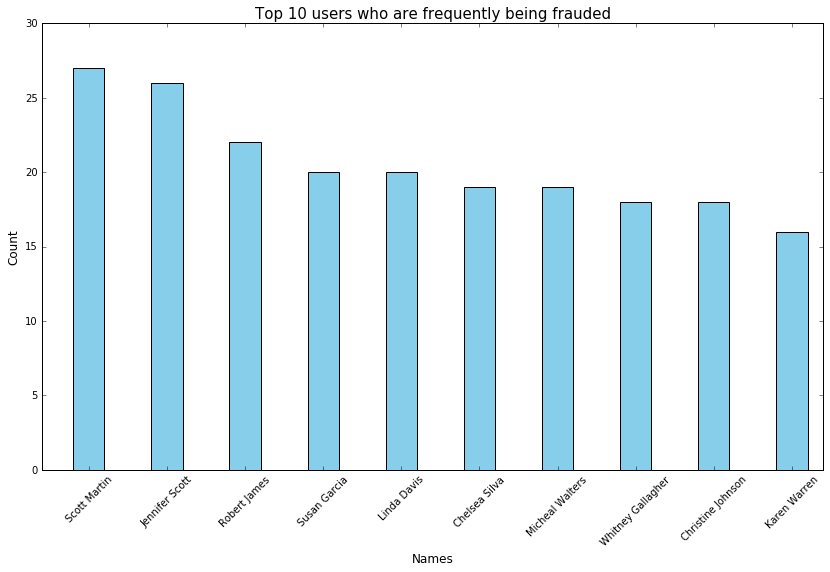

In [14]:
from pyspark.sql.functions import concat_ws
# total counts that being fraud, find the top 10 users
train_1_tmp = fraudTrain_1.withColumn('full_name', concat_ws(' ', fraudTrain_1['first'], fraudTrain_1['last']))
fraud_counts = train_1_tmp.groupBy('full_name').count().orderBy(col('count').desc()).limit(10)

names = fraud_counts.select('full_name').rdd.flatMap(lambda x: x).collect()
count = fraud_counts.select('count').rdd.flatMap(lambda x: x).collect()
# visualize the top 10 names
width=0.4
plt.figure(figsize = (14,8))

cat_indices = list(range(len(names)))
cat_indices_1 = [i+width for i in cat_indices]
bars = plt.bar(cat_indices_1, count, color='skyblue',width=width)
x_position_for_labels = [bar.get_x() + bar.get_width()/2 for bar in bars]
plt.xticks(x_position_for_labels, names, rotation=45)
plt.xlabel('Names',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Top 10 users who are frequently being frauded', fontsize=15)
plt.show()

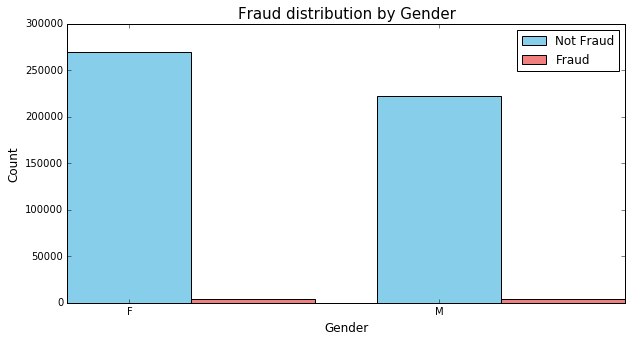

In [15]:
# calculate the distribution for genders with fraud and not fraud
gender_count0 = fraudTrain_0.groupBy('Gender').count().collect()
genders = [row['Gender'] for row in gender_count0]
counts_0 = [row['count'] for row in gender_count0]

gender_count1 = fraudTrain_1.groupBy('Gender').count().collect()
counts_1 = [row['count'] for row in gender_count1]

# visialize the distribution
width=0.4
plt.figure(figsize = (10,5))

cat_indices = list(range(len(genders)))
cat_indices_1 = [i+width for i in cat_indices]
bars = plt.bar(cat_indices, counts_0, color='skyblue',width=width,label='Not Fraud')
x_position_for_labels = [bar.get_x() + bar.get_width()/2 for bar in bars]

plt.xticks(x_position_for_labels, genders)
plt.bar(cat_indices_1, counts_1, color='lightcoral', width=width, label='Fraud')
plt.legend()
plt.xlabel('Gender',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Fraud distribution by Gender', fontsize=15)
plt.show()

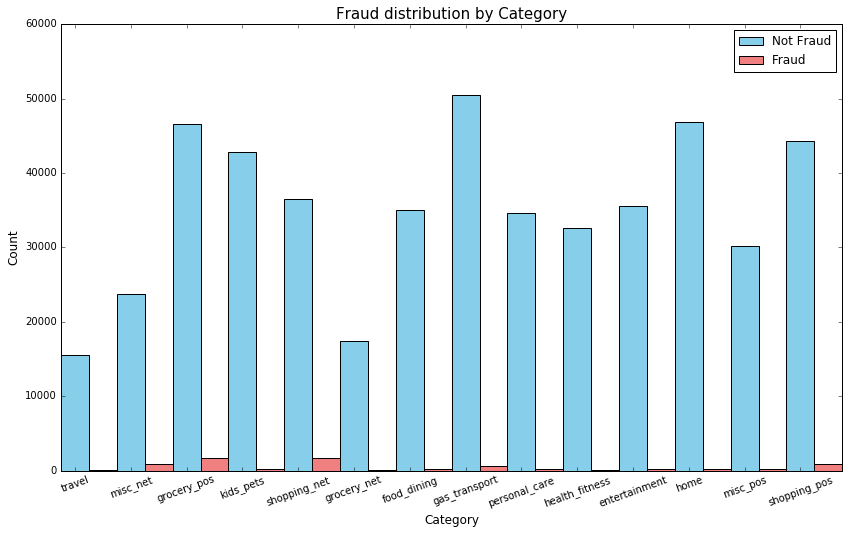

In [16]:
# calculate the distribution of category with fraud and not fraud
category_count0 = fraudTrain_0.groupBy('Category').count().collect()
category = [row['Category'] for row in category_count0]
counts_0 = [row['count'] for row in category_count0]

category_count1 = fraudTrain_1.groupBy('Category').count().collect()
counts_1 = [row['count'] for row in category_count1]

# visualize the distribution
width=0.5
plt.figure(figsize = (14,8))

cat_indices = list(range(len(category)))
cat_indices_1 = [i+width for i in cat_indices]
bars = plt.bar(cat_indices, counts_0, color='skyblue',width=width,label='Not Fraud')
x_position_for_labels = [bar.get_x() + bar.get_width()/2 for bar in bars]

plt.xticks(x_position_for_labels, category, rotation=20)
plt.bar(cat_indices_1, counts_1, color='lightcoral', width=width, label='Fraud')
plt.legend()
plt.xlabel('Category',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Fraud distribution by Category', fontsize=15)
plt.show()

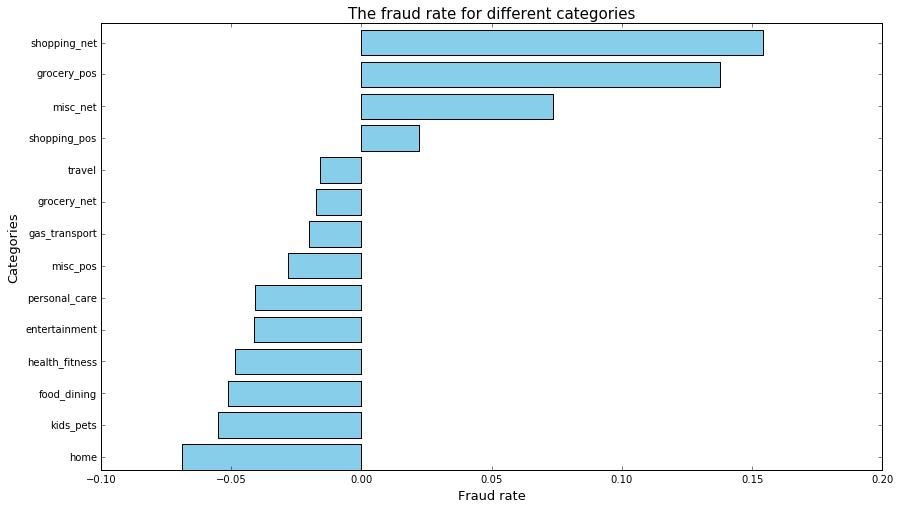

In [17]:
# calculate the fruad level according to different categorials
distribution_0 = fraudTrain_0.groupBy('Category').count()
distribution_0 = distribution_0.withColumn('percentage0', distribution_0['count']/fraudTrain_0.count())

distribution_1 = fraudTrain_1.groupBy('Category').count()
distribution_1 = distribution_1.withColumn('percentage1', distribution_1['count']/fraudTrain_1.count())

merge_df = distribution_0.join(distribution_1, 'Category', 'inner')
merge_df = merge_df.withColumn('difference', col('percentage1')-col('percentage0'))

# plot the fraud level of each category
dt_tmp = merge_df.orderBy('difference').collect()
cats = [row['Category'] for row in dt_tmp]
difference = [row['difference'] for row in dt_tmp]

plt.figure(figsize = (14,8))

cat_indices = list(range(len(cats)))
bars = plt.barh(cat_indices, difference, color='skyblue')
y_position_for_labels = [bar.get_y() + bar.get_height()/2 for bar in bars]

plt.ylabel('Categories', fontsize=13)
plt.xlabel('Fraud rate',fontsize=13)
plt.title('The fraud rate for different categories', fontsize=15)
plt.yticks(y_position_for_labels, cats, fontsize=10)
plt.show()

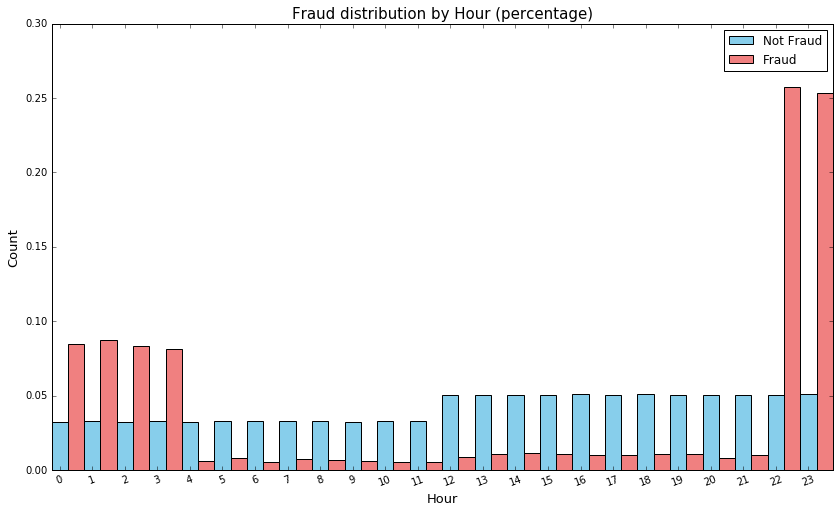

In [18]:
# calculate the distribution for Hour in percentage info in each category
hour_count0 = fraudTrain_0.groupBy('Hour').count().orderBy('Hour')
hour_count0 = hour_count0.withColumn('percentage0', hour_count0['count']/fraudTrain_0.count())

hours = [row['Hour'] for row in hour_count0.collect()]
counts_0 = hour_count0.select('percentage0').rdd.flatMap(lambda x: x).collect()

# visualize the distribution for Category
hour_count1 = fraudTrain_1.groupBy('Hour').count().orderBy('Hour')
hour_count1 = hour_count1.withColumn('percentage0', hour_count1['count']/fraudTrain_1.count())
counts_1 = hour_count1.select('percentage0').rdd.flatMap(lambda x: x).collect()

width=0.5

plt.figure(figsize = (14,8))

cat_indices = list(range(len(hours)))
cat_indices_1 = [i+width for i in cat_indices]
bars = plt.bar(cat_indices, counts_0, color='skyblue', width=width, label='Not Fraud')
x_position_for_labels = [bar.get_x() + bar.get_width()/2 for bar in bars]

plt.xticks(x_position_for_labels, hours, rotation=20)
plt.bar(cat_indices_1, counts_1, color='lightcoral', width=width, label='Fraud')
plt.legend()
plt.xlabel('Hour', fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Fraud distribution by Hour (percentage)',fontsize=15)
plt.show()

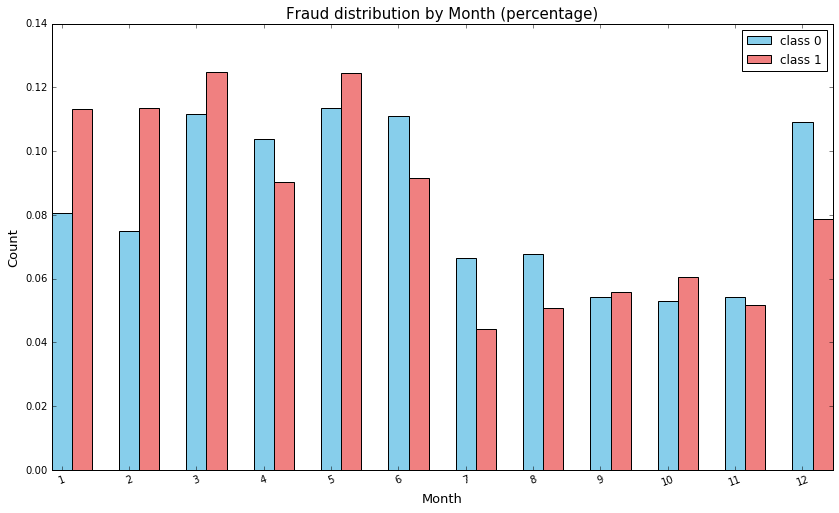

In [19]:
# calculate the distribution for Month in percentage info in each category
month_count0 = fraudTrain_0.groupBy('Month').count().orderBy('Month')
month_count0 = month_count0.withColumn('percentage0', month_count0['count']/fraudTrain_0.count())

month = [row['Month'] for row in month_count0.collect()]
counts_0 = month_count0.select('percentage0').rdd.flatMap(lambda x: x).collect()

# visualize the distribution for Month percentage
month_count1 = fraudTrain_1.groupBy('Month').count().orderBy('Month')
month_count1 = month_count1.withColumn('percentage0', month_count1['count']/fraudTrain_1.count())
counts_1 = month_count1.select('percentage0').rdd.flatMap(lambda x: x).collect()

width=0.3

plt.figure(figsize = (14,8))

cat_indices = list(range(len(month)))
cat_indices_1 = [i+width for i in cat_indices]
bars = plt.bar(cat_indices, counts_0, color='skyblue', width=width, label='class 0')
x_position_for_labels = [bar.get_x() + bar.get_width()/2 for bar in bars]

plt.xticks(x_position_for_labels, month, rotation=20)
plt.bar(cat_indices_1, counts_1, color='lightcoral', width=width, label='class 1')
plt.legend()
plt.xlabel('Month',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Fraud distribution by Month (percentage)',fontsize=15)
plt.show()

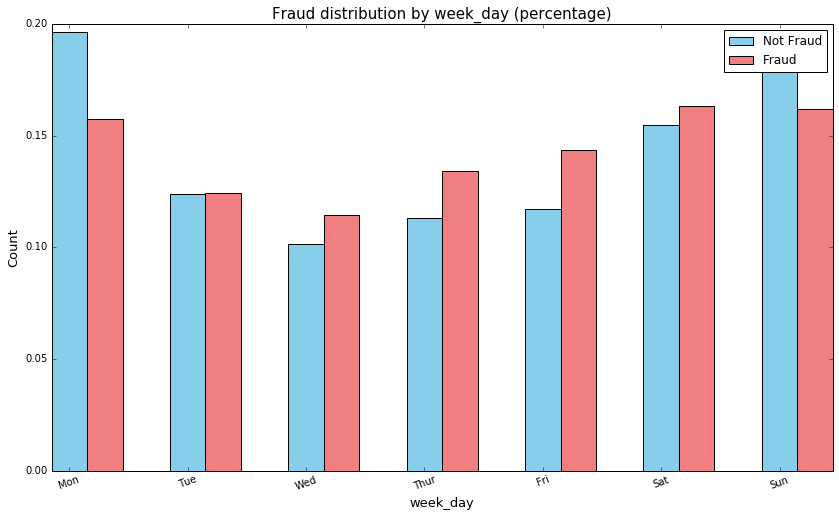

In [20]:
# calculate the distribution for weekday in percentage info in each category
week_count0 = fraudTrain_0.groupBy('week_day').count().orderBy('week_day')
week_count0 = week_count0.withColumn('percentage0', week_count0['count']/fraudTrain_0.count())

week = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
counts_0 = week_count0.select('percentage0').rdd.flatMap(lambda x: x).collect()

# visualize the distribution for weekday
week_count1 = fraudTrain_1.groupBy('week_day').count().orderBy('week_day')
week_count1 = week_count1.withColumn('percentage0', week_count1['count']/fraudTrain_1.count())
counts_1 = week_count1.select('percentage0').rdd.flatMap(lambda x: x).collect()

width=0.3

plt.figure(figsize = (14,8))

cat_indices = list(range(len(week)))
cat_indices_1 = [i+width for i in cat_indices]
bars = plt.bar(cat_indices, counts_0, color='skyblue', width=width, label='Not Fraud')
x_position_for_labels = [bar.get_x() + bar.get_width()/2 for bar in bars]

plt.xticks(x_position_for_labels, week, rotation=20)
plt.bar(cat_indices_1, counts_1, color='lightcoral', width=width, label='Fraud')
plt.legend()
plt.xlabel('week_day',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Fraud distribution by week_day (percentage)',fontsize=15)
plt.show()

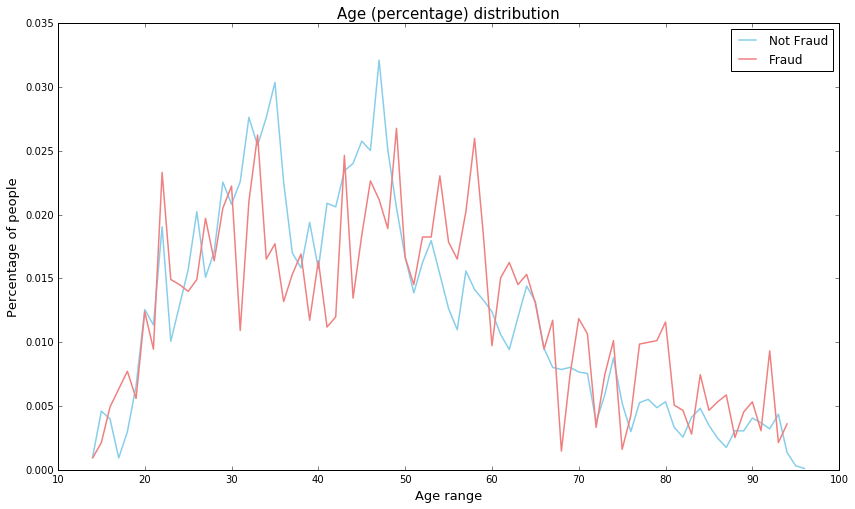

In [21]:
# calculate the percentage of age distribution of fraud and not fraud
distribution_0 = fraudTrain_0.groupBy('age').count().orderBy('age')
distribution_0 = distribution_0.withColumn('density', distribution_0['count']/fraudTrain_0.count())

x_vals_0 = distribution_0.select('age').rdd.flatMap(lambda x: x).collect()
y_vals_0 = distribution_0.select("density").rdd.flatMap(lambda x: x).collect()

distribution_1 = fraudTrain_1.groupBy('age').count().orderBy('age')
distribution_1 = distribution_1.withColumn('density', distribution_1['count']/fraudTrain_1.count())

x_vals_1 = distribution_1.select('age').rdd.flatMap(lambda x: x).collect()
y_vals_1 = distribution_1.select("density").rdd.flatMap(lambda x: x).collect()

# visualize the age distribution
plt.figure(figsize = (14,8))
plt.plot(x_vals_0, y_vals_0, color='skyblue',linewidth=1.5,label='Not Fraud')
plt.plot(x_vals_1, y_vals_1, color='lightcoral',linewidth=1.5, label='Fraud')
plt.legend()
plt.xlabel('Age range', fontsize=13)
plt.ylabel('Percentage of people',fontsize=13)
plt.title('Age (percentage) distribution',fontsize=15)
plt.show()

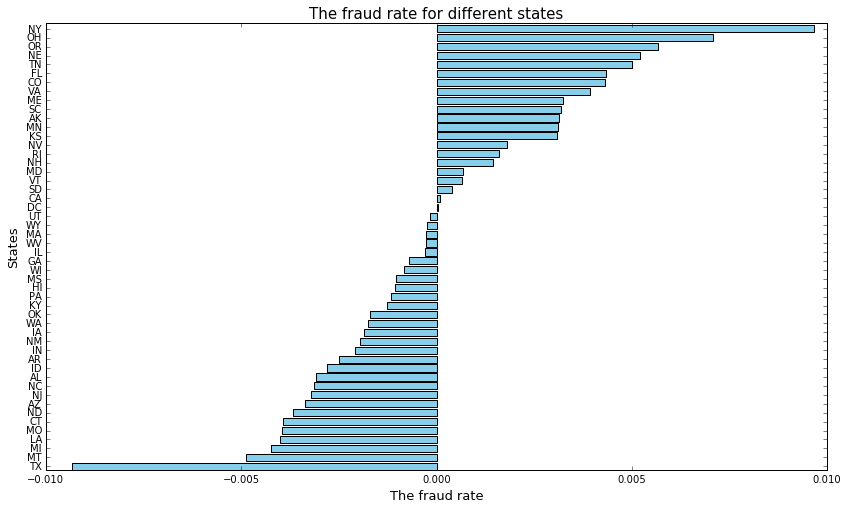

In [22]:
# calcaulate the fruad level according to different states
distribution_0 = fraudTrain_0.groupBy('state').count()
distribution_0 = distribution_0.withColumn('percentage0', distribution_0['count']/fraudTrain_0.count())

distribution_1 = fraudTrain_1.groupBy('state').count()
distribution_1 = distribution_1.withColumn('percentage1', distribution_1['count']/fraudTrain_1.count())

merge_df = distribution_0.join(distribution_1, 'state', 'inner')
merge_df = merge_df.withColumn('difference', col('percentage1')-col('percentage0'))

# visualize the fraud level of each states
dt_tmp = merge_df.orderBy('difference').collect()
cats = [row['state'] for row in dt_tmp]
difference = [row['difference'] for row in dt_tmp]

plt.figure(figsize = (14,8))

cat_indices = list(range(len(cats)))
bars = plt.barh(cat_indices, difference, color='skyblue')
y_position_for_labels = [bar.get_y() + bar.get_height()/2 for bar in bars]

plt.yticks(y_position_for_labels, cats, fontsize=10)
plt.ylabel('States', fontsize=13)
plt.xlabel('The fraud rate', fontsize=13)
plt.title('The fraud rate for different states', fontsize=15)
plt.show()

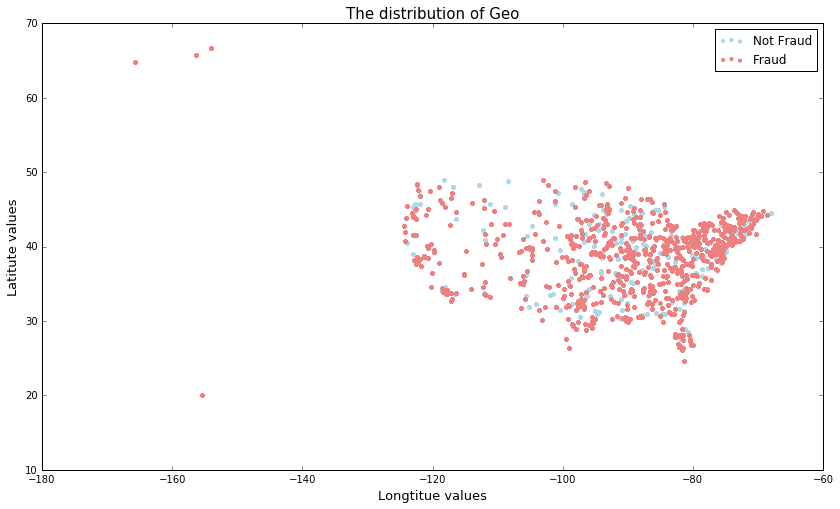

In [23]:
# map longtitute and latitude in the scatter plot
long_lat_0 = fraudTrain_0.select('long','lat').collect()
long_0 = [row['long'] for row in long_lat_0]
lat_0 = [row['lat'] for row in long_lat_0]

long_lat_1 = fraudTrain_1.select('long','lat').collect()
long_1 = [row['long'] for row in long_lat_1]
lat_1 = [row['lat'] for row in long_lat_1]

plt.figure(figsize = (14,8))
plt.scatter(long_0, lat_0, color='lightblue', s=10, label='Not Fraud')
plt.scatter(long_1, lat_1, color='lightcoral', s=10, label='Fraud')
plt.legend()
plt.xlabel('Longtitue values', fontsize=13)
plt.ylabel('Latitute values', fontsize=13)
plt.title('The distribution of Geo', fontsize=15)
plt.show()

## Plot the heatmap for further reference

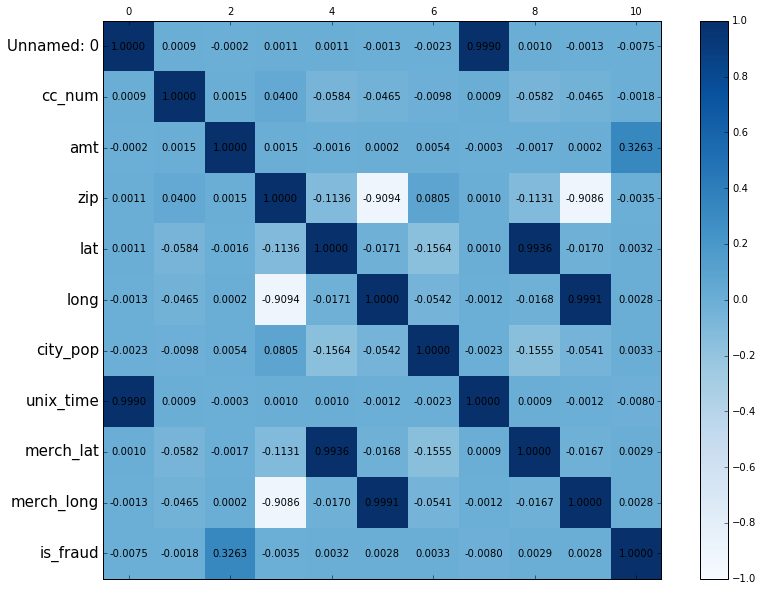

In [24]:
# plot the heatmap between different variables
# Function to compute and display the correlation matrix for numeric columns
def correlation_matrix(data, numeric_columns):
    # Using Vector Assembler to combine numerical columns into a feature vector
    assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
    assembled_data = assembler.transform(data)

    # Calculate Pearson correlation matrix
    correlation_matrix = Correlation.corr(assembled_data, "features").head()[0]

    # Convert the matrix into python list form
    correlation_list = correlation_matrix.toArray().tolist()
    
    fig, ax = plt.subplots(figsize=(14,10))

    for i, feature_i in enumerate(numeric_columns):
        for j, feature_j in enumerate(numeric_columns):
            ax.text(j,i,"{:.4f}".format(correlation_list[i][j]),ha='center',va='center')
            
    cax = ax.matshow(correlation_list, cmap="Blues", vmin=-1, vmax=1)
    plt.yticks(range(len(numeric_columns)), numeric_columns, fontsize=15)
    plt.colorbar(cax)
    plt.show()

correlation_matrix(fraudTrain, numeric_columns)

# Build the models for comparison

In [25]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import expr

In [26]:
# drop some unncessary features that will not feed into models
columns_drop = ['Unnamed: 0', 'trans_date_trans_time', 'dob', 'week_day', 'trans_num', 
                'street', 'city', 'merch_lat', 'merch_long', 'zip']
fraudTrain = fraudTrain.drop(*columns_drop)
fraudTest = fraudTest.drop(*columns_drop)
print('There are {} features in train dataset'.format(len(fraudTrain.columns)))
print('There are {} features in test dataset'.format(len(fraudTest.columns)))

There are 17 features in train dataset
There are 17 features in test dataset


In [27]:
# gain the current num features and cat features
num_features, cat_features = feature_division(fraudTrain, fraudTrain.columns)
num_features = [i for i in num_features if i!='is_fraud']
print('Numeric columns are: ', num_features)
print('\nCategorical columns are: ', cat_features) 

Numeric columns are:  ['cc_num', 'amt', 'lat', 'long', 'city_pop', 'unix_time', 'Hour', 'Month', 'age']

Categorical columns are:  ['merchant', 'category', 'first', 'last', 'gender', 'state', 'job']


## Normalization

In [28]:
# define a function to normalize all num features
def Normalization(num_features):
    
    # store stages for pipeline
    stage_numeric = []
    
    # standarize data with StandardScale Method
    numeric_assemble = VectorAssembler(inputCols=num_features, outputCol="scaled_data")
    scale = StandardScaler(inputCol="scaled_data", outputCol="standardized")
    
    # store features into pipeline
    stage_numeric.extend([numeric_assemble, scale])
    
    return stage_numeric 

stage_numeric = Normalization(num_features)

## Encode

In [29]:
# define a function to choose proper encode method
def choose_encode_method(data, cat_features):  
    
    # choose suitable encode methods
    # for categories over 10, choose onehot encoding method, otherwise label encoding method
    onehot_feature = [col for col in cat_features if data.select(col).distinct().count()<10]
    labelencode_feature = [col for col in cat_features if col not in onehot_feature]
    
    return onehot_feature, labelencode_feature

onehot_feature, labelencode_feature = choose_encode_method(fraudTrain, cat_features)
print('features for one hot encoding: ', onehot_feature)
print('features for label encoding: ', labelencode_feature)

features for one hot encoding:  ['gender']
features for label encoding:  ['merchant', 'category', 'first', 'last', 'state', 'job']


In [30]:
# define a function to implement one-hot encoding 
def one_hot_encoding(onehot_feature):
    
    # store stages for pipeline, and features for inputting into models
    stage_onehot = []
    feature_onehot = []
    
    # encode categorial features with one-hot method
    for feature in onehot_feature:
        indexer_colname = '{}_index'.format(feature)
        encoder_colname = '{}_encode'.format(feature)
        indexer = StringIndexer(inputCol=feature, outputCol=indexer_colname)
        encoder = OneHotEncoder(inputCol=indexer_colname, outputCol=encoder_colname)
        
        # store stages into pipeline, store features for input
        stage_onehot.extend([indexer, encoder])
        feature_onehot.append(encoder_colname)
        
    return stage_onehot, feature_onehot
    
stage_onehot, feature_onehot = one_hot_encoding(onehot_feature)

In [31]:
# define a function to implement label encoding
def label_encoding(labelencode_feature):
    
    # store stages for pipeline, and features for inputting into models
    stage_label = []
    feature_label = []
    
    # encode categorial features with label encoding method
    for feature in labelencode_feature:
        indexer_colname = '{}_index'.format(feature)
        indexer = StringIndexer(inputCol=feature, outputCol=indexer_colname)
        
        # store stages into pipeline, store features for input
        stage_label.extend([indexer])
        feature_label.append(indexer_colname)
        
    return stage_label, feature_label
    
stage_label, feature_label = label_encoding(labelencode_feature)

In [32]:
# Assembly the selected features that will feed into the models
feature_columns = ['standardized'] + feature_onehot + feature_label
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# pass all data into pipeline for transformation 
pipeline = Pipeline(stages= stage_numeric + stage_onehot + stage_label + [assembler])

## Deal with train data

In [33]:
# pipeline the train data
fraudTrain_transfrom = pipeline.fit(fraudTrain).transform(fraudTrain)

## Deal with test data

In [34]:
# pipeline the test data
fraudTest_transfrom = pipeline.fit(fraudTest).transform(fraudTest)
fraudTest_transfrom.show(2)

+----------------+--------------------+-------------+-----+---------+-------+------+-----+-------+---------+--------+--------------------+----------+--------+----+-----+---+--------------------+--------------------+------------+-------------+--------------+--------------+-----------+----------+-----------+---------+--------------------+
|          cc_num|            merchant|     category|  amt|    first|   last|gender|state|    lat|     long|city_pop|                 job| unix_time|is_fraud|Hour|Month|age|         scaled_data|        standardized|gender_index|gender_encode|merchant_index|category_index|first_index|last_index|state_index|job_index|            features|
+----------------+--------------------+-------------+-----+---------+-------+------+-----+-------+---------+--------+--------------------+----------+--------+----+-----+---+--------------------+--------------------+------------+-------------+--------------+--------------+-----------+----------+-----------+---------+-----

## Define evaluation matrix

In [35]:
# define the evaluation indicators, namely accuracy, precision, recall and f1-score
def evaluation_criteria(predictions):
    
    evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', predictionCol='prediction')
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName:'accuracy'})
    
    accuracy = round(accuracy, 4)
    
    FN = predictions.filter((predictions['is_fraud']==1) & (predictions['prediction']==0)).count()
    TP = predictions.filter((predictions['is_fraud']==1) & (predictions['prediction']==1)).count()
    
    TN = predictions.filter((predictions['is_fraud']==0) & (predictions['prediction']==0)).count()
    FP = predictions.filter((predictions['is_fraud']==0) & (predictions['prediction']==1)).count()
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)
    recall = TP/(TP+FN)
    
    evaluation_results = {
        'accuracy':accuracy,
        'recall':recall,
        'False Negative Rate':FNR,
        'False Positive Rate':FPR
    }
    
    return evaluation_results

## Logistic regression

In [36]:
# train the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='is_fraud')
model_lr = lr.fit(fraudTrain_transfrom)

# gain the results of linear regression model
predictions_lr = model_lr.transform(fraudTest_transfrom)

In [37]:
# check the evaluation criteria
results = evaluation_criteria(predictions_lr)
print('The evaluation result is\n', results)

The evaluation result is
 {'accuracy': 0.9948, 'False Positive Rate': 0.0012851018543618164, 'recall': 0.0025188916876574307, 'False Negative Rate': 0.9974811083123426}


In [38]:
# plot the confusion matrix for logistic regression
confusion_matrix_lr = predictions_lr.groupBy('prediction').pivot('is_fraud').count().na.fill(0)
confusion_matrix_lr.show()

+----------+-----+---+
|prediction|    0|  1|
+----------+-----+---+
|       0.0|99475|396|
|       1.0|  128|  1|
+----------+-----+---+



## Decision Tree

In [39]:
# train the decision tree model
dc = DecisionTreeClassifier(featuresCol='features', labelCol='is_fraud', maxBins=700)
model_dc = dc.fit(fraudTrain_transfrom)

# gain the results of decision tree model
predictions_dc = model_dc.transform(fraudTest_transfrom)

In [40]:
# check the evaluation criteria
results = evaluation_criteria(predictions_dc)
print('The evaluation result is\n', results)

The evaluation result is
 {'accuracy': 0.9954, 'False Positive Rate': 0.002439685551640011, 'recall': 0.4609571788413098, 'False Negative Rate': 0.5390428211586902}


In [41]:
# gain confusion matrix for decision tree
confusion_matrix_dc = predictions_dc.groupBy('prediction').pivot('is_fraud').count().na.fill(0)
confusion_matrix_dc.show()

+----------+-----+---+
|prediction|    0|  1|
+----------+-----+---+
|       0.0|99360|214|
|       1.0|  243|183|
+----------+-----+---+



## Random Forest

In [42]:
# train the random forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud', maxBins=700)
model_rf = rf.fit(fraudTrain_transfrom)

# gain the results of random forest model
predictions_rf = model_rf.transform(fraudTest_transfrom)

In [43]:
# check the evaluation criteria
results = evaluation_criteria(predictions_rf)
print('The evaluation result is\n', results)

The evaluation result is
 {'accuracy': 0.9968, 'False Positive Rate': 0.0004116341877252693, 'recall': 0.2871536523929471, 'False Negative Rate': 0.7128463476070529}


In [44]:
# gain confusion matrix for random tree
confusion_matrix = predictions_rf.groupBy('prediction').pivot('is_fraud').count().na.fill(0)
confusion_matrix.show()

+----------+-----+---+
|prediction|    0|  1|
+----------+-----+---+
|       0.0|99562|283|
|       1.0|   41|114|
+----------+-----+---+



## plot feature importance

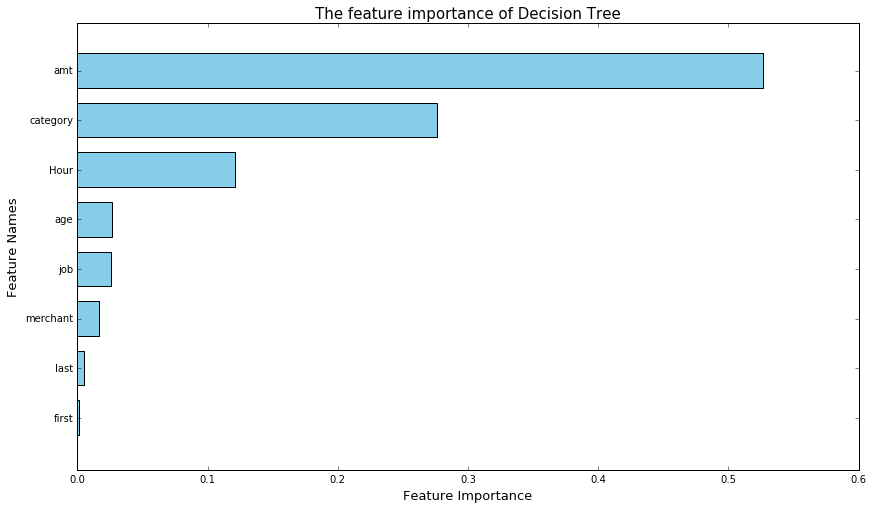

In [45]:
# gain the top 6 feature importance
featureCols = num_features + onehot_feature + labelencode_feature
feature_importance= model_dc.featureImportances
important_list = [(featureCols[i],importance) for i,importance in enumerate(feature_importance) if importance !=0]
important_list.sort(key=lambda x:x[1], reverse=True)
importance_top = important_list

# visualize the top feature importance
feature_name, importance = zip(*importance_top[::-1])

cat_indices = [i-0.3 for i in list(range(len(feature_name)))]

plt.figure(figsize=(14,8))
bars = plt.barh(cat_indices, importance, color='skyblue', height=0.7)
y_position_for_labels = [bar.get_y() + bar.get_height()/2 for bar in bars]
plt.yticks(y_position_for_labels, feature_name, fontsize=10)
plt.xlabel('Feature Importance', fontsize=13)
plt.ylabel('Feature Names', fontsize=13)
plt.title('The feature importance of Decision Tree', fontsize=15)
plt.show()

## Discover the distribution of wrongly classified data

In [46]:
## select data of wrong classification and right classification respectively
wrongclass = predictions_dc.filter((col('is_fraud')==1) & (col('prediction')==0))
rightclass = predictions_dc.filter((col('is_fraud')==1) & (col('prediction')==1))

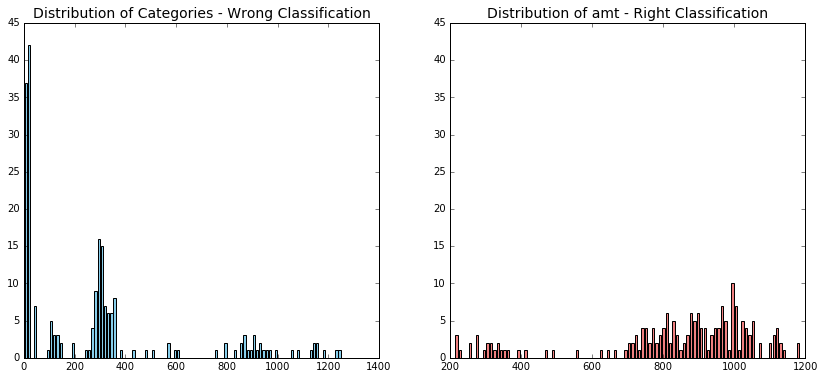

In [47]:
# plot the distribution of wrong classification and right classification about amt
fig, axes = plt.subplots(1,2,figsize=(14,6))

# plot the amt distribution for wrong classification
histogram_data = wrongclass.select('amt').rdd.flatMap(lambda x: x).histogram(100)
axes[0].bar(histogram_data[0][:-1], histogram_data[1], width=0.7*(histogram_data[0][1]-histogram_data[0][0]), color='skyblue')
axes[0].set_title("Distribution of amt - Wrong Classification", fontsize=14)
axes[0].set_ylim(0,45)

# plot the amt distribution for right classification
histogram_data = rightclass.select('amt').rdd.flatMap(lambda x: x).histogram(100)
axes[1].bar(histogram_data[0][:-1], histogram_data[1], width=0.7*(histogram_data[0][1]-histogram_data[0][0]), color='lightcoral')
axes[1].set_title("Distribution of amt - Right Classification", fontsize=14)
axes[1].set_ylim(0,45)
plt.show()

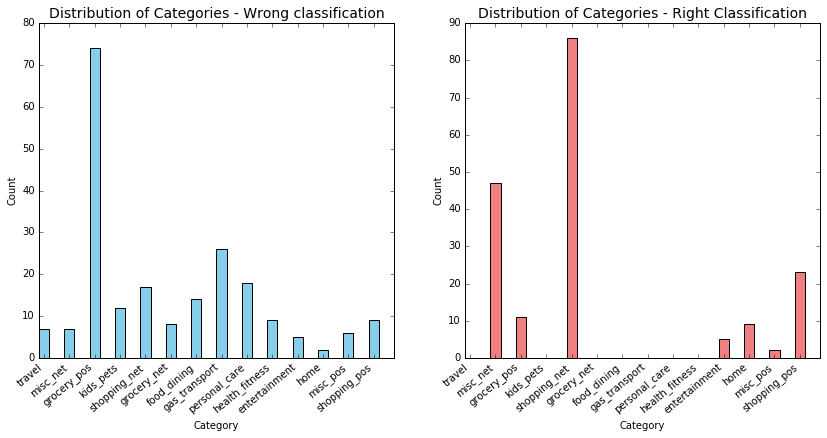

In [48]:
# plot the distribution of wrong classification and right classification about category

# calculate the count for wrong classfication
category_count0 = wrongclass.groupBy('Category').count().collect()
category = [row['Category'] for row in category_count0]
counts_0 = [row['count'] for row in category_count0]

# calculate the count for right classfication
category_count1 = rightclass.groupBy('Category').count().collect()
category1 = [row['Category'] for row in category_count1]
counts_1 = [row['count'] for row in category_count1]

# store the categories that has not appeared in right classification
for cat in category:
    if cat not in category1:
        category1.append(cat)
        counts_1.append(0)
cat_count_dict = dict(zip(category1, counts_1))

counts_2 = [cat_count_dict[cat] for cat in category]

# visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
width = 0.4

cat_indices = list(range(len(category)))
bars = axes[0].bar(cat_indices, counts_0, color='skyblue', width=width)
x_position_for_labels = [bar.get_x() + bar.get_width() / 2 for bar in bars]

axes[0].set_xticks(x_position_for_labels)
axes[0].set_xticklabels(category, rotation=40, ha='right')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Categories - Wrong classification', fontsize=14)

bars = axes[1].bar(cat_indices, counts_2, color='lightcoral', width=width)
x_position_for_labels1 = [bar.get_x() + bar.get_width() / 2 for bar in bars]

axes[1].set_xticks(x_position_for_labels)
axes[1].set_xticklabels(category, rotation=40, ha='right')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Categories - Right Classification', fontsize=14)

plt.show()

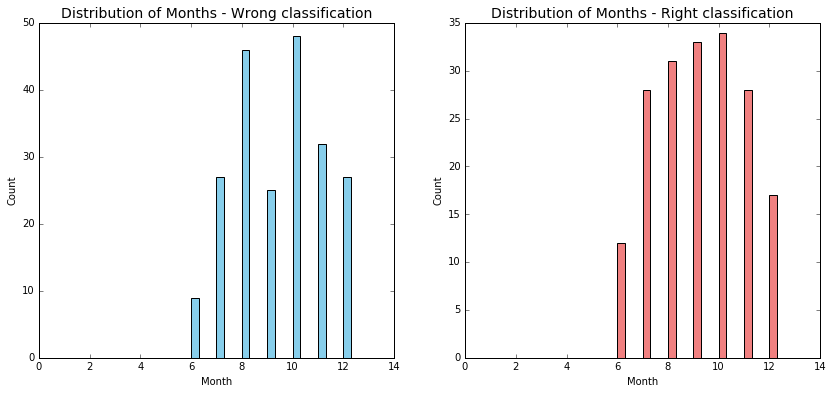

In [49]:
# calculate the distribution for Month in percentage info in each category

# calculate the month count for wrong classification
right_month = [i+1 for i in range(12)]
month_count0 = wrongclass.groupBy('Month').count().orderBy('Month')

month = [row['Month'] for row in month_count0.collect()]
counts_0 = month_count0.select('count').rdd.flatMap(lambda x: x).collect()

# add the month that not appeared into month list
for mon in right_month:
    if mon not in month:
        month.append(mon)
        counts_0.append(0)
mon_count_dict = dict(zip(month, counts_0))
counts_0 = [mon_count_dict[mon] for mon in right_month]

# calculate the month count for right classification
month_count1 = rightclass.groupBy('Month').count().orderBy('Month')
month1 = [row['Month'] for row in month_count1.collect()]
counts_1 = month_count1.select('count').rdd.flatMap(lambda x: x).collect()

# add the month that not appeared into month list
for mon in right_month:
    if mon not in month1:
        month1.append(mon)
        counts_1.append(0)
mon_count_dict1 = dict(zip(month1, counts_1))
counts_1 = [mon_count_dict1[mon] for mon in right_month]

# visualize the distribution for Month percentage
width=0.3

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(right_month, counts_0, color='skyblue', width=width)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Months - Wrong classification', fontsize=14)

axes[1].bar(right_month, counts_1, color='lightcoral', width=width)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Months - Right classification', fontsize=14)

plt.show()

## Feature engineering of downsampling to improve model performance

### Loop for downsample

In [53]:
# set downsample propotion list
porportion_list1 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

# select the majority category and minority category
majority = fraudTrain.filter(col('is_fraud')==0)
minority = fraudTrain.filter(col('is_fraud')==1)

FPR_list = []
FNR_list = []
model_list = []

# begin loop for different downsample propotion
for p in porportion_list1:

    downsample_fraction = p
    downsample = majority.sample(False, downsample_fraction)
    balanced_data = downsample.unionAll(minority)
    
    # pipeline the balanced data
    balanced_transfrom = pipeline.fit(balanced_data).transform(balanced_data)
    
    # train a new decision tree for balanced data
    dc1 = DecisionTreeClassifier(featuresCol='features', labelCol='is_fraud')
    model_dc1 = dc.fit(balanced_transfrom)
    model_list.append(model_dc1)

    # gain the results of decision tree model after rebalancing
    predictions_dc1 = model_dc1.transform(fraudTest_transfrom)
    
    results = evaluation_criteria(predictions_dc1)
    
    # gain FPR and FNP for different models
    FPR_list.append(results['False Positive Rate'])
    FNR_list.append(results['False Negative Rate'])
    
    print('The evaluation result is\n', results)

The evaluation result is
 {'accuracy': 0.9813, 'False Positive Rate': 0.016937240846159253, 'recall': 0.5516372795969773, 'False Negative Rate': 0.44836272040302266}
The evaluation result is
 {'accuracy': 0.9817, 'False Positive Rate': 0.016535646516671186, 'recall': 0.5390428211586902, 'False Negative Rate': 0.4609571788413098}
The evaluation result is
 {'accuracy': 0.9888, 'False Positive Rate': 0.00956798490005321, 'recall': 0.5869017632241813, 'False Negative Rate': 0.41309823677581864}
The evaluation result is
 {'accuracy': 0.9908, 'False Positive Rate': 0.007549973394375672, 'recall': 0.5692695214105793, 'False Negative Rate': 0.43073047858942065}
The evaluation result is
 {'accuracy': 0.9913, 'False Positive Rate': 0.0070981797737015954, 'recall': 0.6020151133501259, 'False Negative Rate': 0.3979848866498741}
The evaluation result is
 {'accuracy': 0.9906, 'False Positive Rate': 0.00783108942501732, 'recall': 0.5969773299748111, 'False Negative Rate': 0.40302267002518893}
The eva

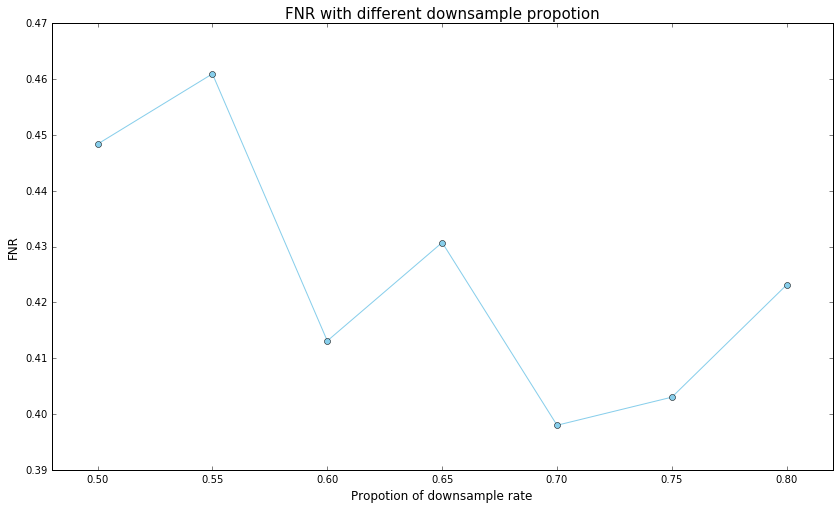

In [54]:
# plot the line chart of FNR
plt.figure(figsize=(14,8))
plt.plot(porportion_list1, FNR_list, marker='o', color='skyblue')
plt.xlim(left=0.48, right=0.82)
plt.xlabel('Propotion of downsample rate', fontsize=12)
plt.ylabel('FNR', fontsize=12)
plt.title('FNR with different downsample propotion', fontsize=15)
plt.show()

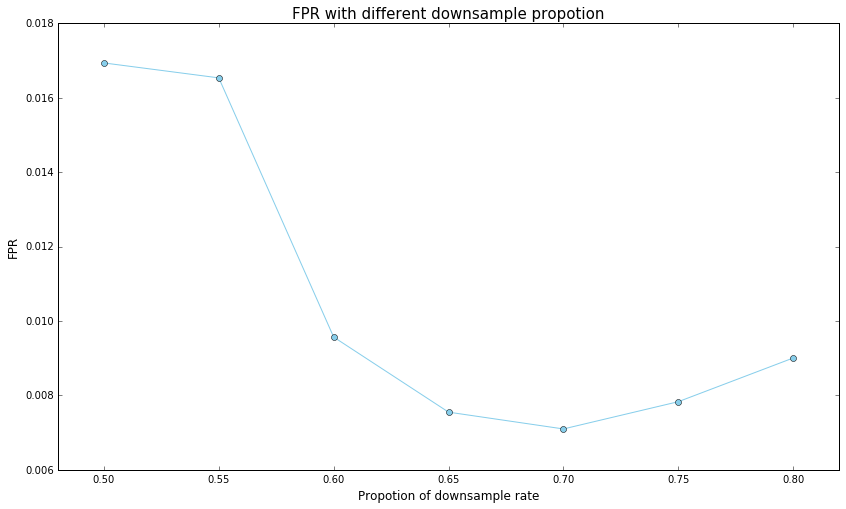

In [55]:
# plot the line chart of FPR
plt.figure(figsize=(14,8))
plt.plot(porportion_list1, FPR_list, marker='o', color='skyblue')
plt.xlim(left=0.48, right=0.82)
plt.xlabel('Propotion of downsample rate', fontsize=12)
plt.ylabel('FPR', fontsize=12)
plt.title('FPR with different downsample propotion', fontsize=15)
plt.show()

In [56]:
# select the best downsample rate and calculate how many data are remained after downsampling
downsample_fraction = 0.7
downsample = majority.sample(False, downsample_fraction)
balanced_data = downsample.unionAll(minority)

print('There are {} data after undersample'.format(balanced_data.count()))

There are 352794 data after undersample


In [57]:
# calculate the number of data in each category
majority1 = balanced_data.filter(col('is_fraud')==0)
minority1 = balanced_data.filter(col('is_fraud')==1)

print('After balancing, the majority of data is: {}'.format(majority1.count()))
print('After balancing, the minority of data is: {}'.format(minority1.count()))

After balancing, the majority of data is: 345288
After balancing, the minority of data is: 7506


+--------+------+-----------------+
|is_fraud| count|       Percentage|
+--------+------+-----------------+
|       1|  7506|2.127587203864011|
|       0|345288|97.87241279613599|
+--------+------+-----------------+



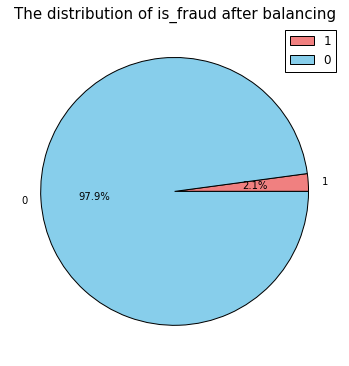

In [58]:
# After downsampling, visualize the distribution of people of fraud and not fraud
distribution = balanced_data.groupBy('is_fraud').count().withColumn("Percentage", (col("count") / balanced_data.count()) * 100)
distribution.show()

categories = distribution.select('is_fraud').rdd.flatMap(lambda x: x).collect()
counts = distribution.select("count").rdd.flatMap(lambda x: x).collect()

colors = ['lightcoral', 'skyblue']
plt.figure(figsize = (6,6))
plt.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=0)
plt.legend(categories, loc='best')
plt.title('The distribution of is_fraud after balancing', fontsize=15)
plt.show()